## Redundancy Metrics
### Kiri Daust

In [1]:
import vamp
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import os
import pyrle

The below is the main function. I take it apart and show how it works further on.

In [2]:
def calc_redundancy(audio_file,filter_size = 25, remove_len = 5, base_pattern_length = 5):
    sr, audio = wavfile.read(audio_file)
    audio = np.asarray(audio).astype('float32')
    data = vamp.collect(audio, sr, "mtg-melodia:melodia")
    hop, melody = data['vector']
    melody_pos = melody[:]
    melody_pos[melody<=0] = None
    mel_norest = melody_pos[~np.isnan(melody_pos)]
    result = savgol_filter(mel_norest, filter_size, 5)
    pt4 = np.where(result==0, 1, result)
    float_midi = 69 + 12*np.log2(pt4/440.)
    int_midi = np.array([round(x) for x in float_midi])

    for (i,f) in enumerate(float_midi): 
        if f < 40: 
            float_midi[i] = 0 
            int_midi[i] = 0 

    rle = pyrle.Rle(int_midi)
    rle_vals = rle.values
    rle_runs = rle.runs
    final_notes = rle_vals[rle_runs > remove_len]
    note_diff = np.ediff1d(final_notes)
    note_diff = note_diff + abs(min(note_diff))
    note_diff = note_diff.astype(int)

    numnotes = len(note_diff)
    breaks = np.arange(0,numnotes,base_pattern_length)
    res = np.zeros(0)
    for i in range(0,len(breaks)-1):
        base_pattern = note_diff[breaks[i]:breaks[i+1]]
        bpstr = ''.join(map(str, base_pattern))
        for j in range(i+1, len(breaks)-1):
            p2str = ''.join(map(str, note_diff[breaks[j]:breaks[j+1]]))
            res = np.append(res,fuzz.ratio(bpstr,p2str))
    return(np.mean(res), np.std(res))

Testing the redundancy function on the first 50 pieces in George's music database in disco, jazz, pop, and blues

In [12]:
genres_test = ["disco","jazz","pop","blues"]
genre_res = dict()
for gen in genres_test:
    genre_res[gen] = np.zeros(0)

for gen in genres_test:
    files = os.listdir("./genres_original/" + gen)
    print("Processing " + gen)
    for i in range(0,50):
        audio_file = "./genres_original/" + gen + "/" + files[i]
        ##print(audio_file)
        res = calc_redundancy(audio_file,25,5,10)
        genre_res[gen] = np.append(genre_res[gen],res[0])

Processing disco
Processing jazz
Processing pop
Processing blues


In [13]:
for key, values in genre_res.items():
    print(key + ": " + str(np.mean(values)))

disco: 64.0000752405964
jazz: 56.7318694555682
pop: 64.62658263958232
blues: 63.18743267782951


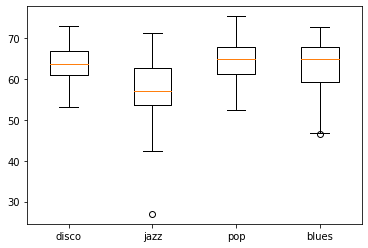

In [14]:
labels, data = [*zip(*genre_res.items())]
plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

## Investigating the Function

In [18]:
sr, audio = wavfile.read("./train01.wav")
audio = np.asarray(audio).astype('float32')
data = vamp.collect(audio, sr, "mtg-melodia:melodia") ##run the melodia plugin to extract the melodic frequency

In [19]:
hop, melody = data['vector']
timestamps = 8 * 128/44100.0 + np.arange(len(melody)) * (128/44100.0)##for plotting

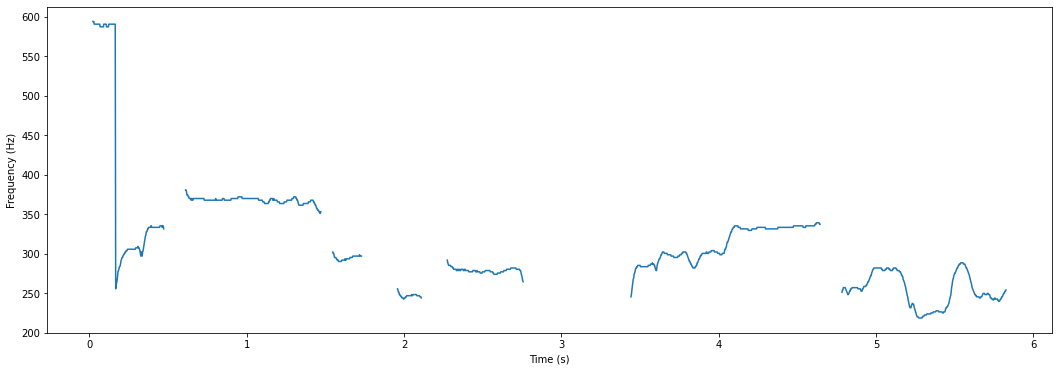

In [20]:
melody_pos = melody[:]
melody_pos[melody<=0] = None
plt.figure(figsize=(18,6))
plt.plot(timestamps[0:2000], melody_pos[0:2000])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

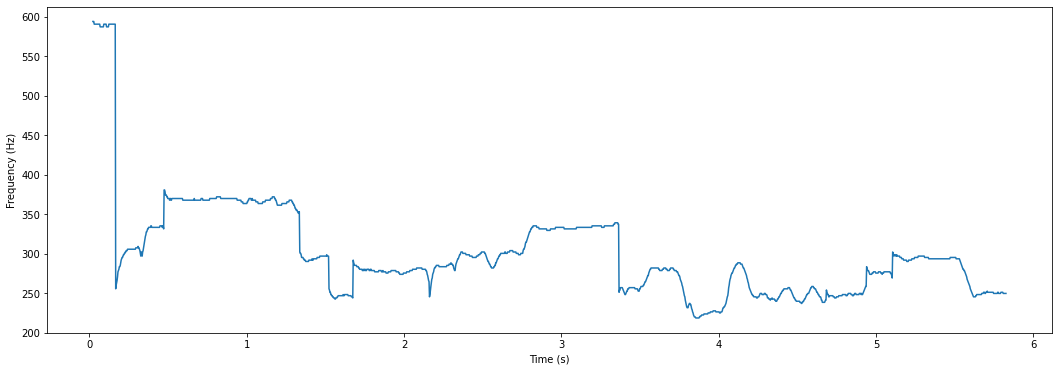

In [21]:
##we only care about the melody, so let's remove the breaks without melody
mel_norest = melody_pos[~np.isnan(melody_pos)]
plt.figure(figsize=(18,6))
plt.plot(timestamps[0:2000], mel_norest[0:2000])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

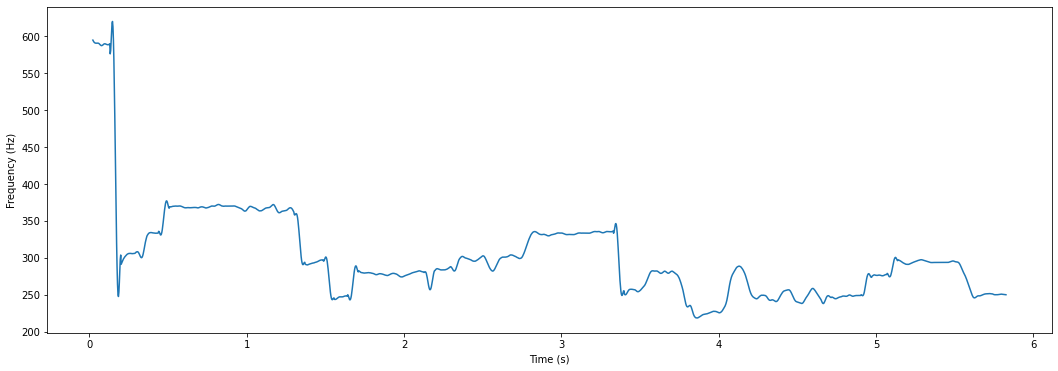

In [22]:
##run a filter to smooth out little bumps (e.g. vibrato)
result = savgol_filter(mel_norest, 25, 5)

plt.figure(figsize=(18,6))
plt.plot(timestamps[0:2000], result[0:2000])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [23]:
##now convert to midi note number
pt4 = np.where(result==0, 1, result)
# convert to midi 
float_midi = 69 + 12*np.log2(pt4/440.)
# quantize midi 
int_midi = np.array([round(x) for x in float_midi])


for (i,f) in enumerate(float_midi): 
    if f < 40: 
        float_midi[i] = 0 
        int_midi[i] = 0 

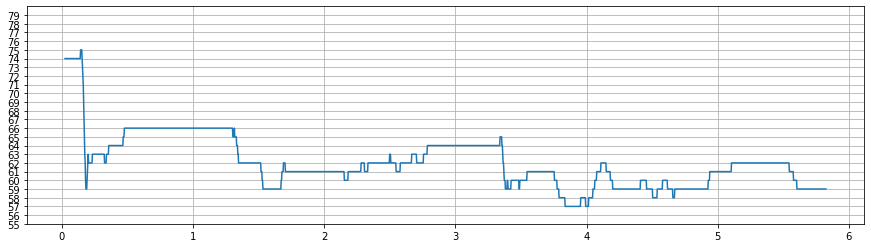

In [24]:
plt.figure(figsize=(15,4))
plt.plot(timestamps[0:2000],int_midi[0:2000])
plt.ylim(55, 80)
plt.grid(True)
plt.yticks(np.arange(55,80))
plt.show()

In [26]:
##Note some of the short step values. We don't want these. Let's remove everything < 5 units
rle = pyrle.Rle(int_midi)
rle_vals = rle.values
rle_runs = rle.runs
final_notes = rle_vals[rle_runs > 5]

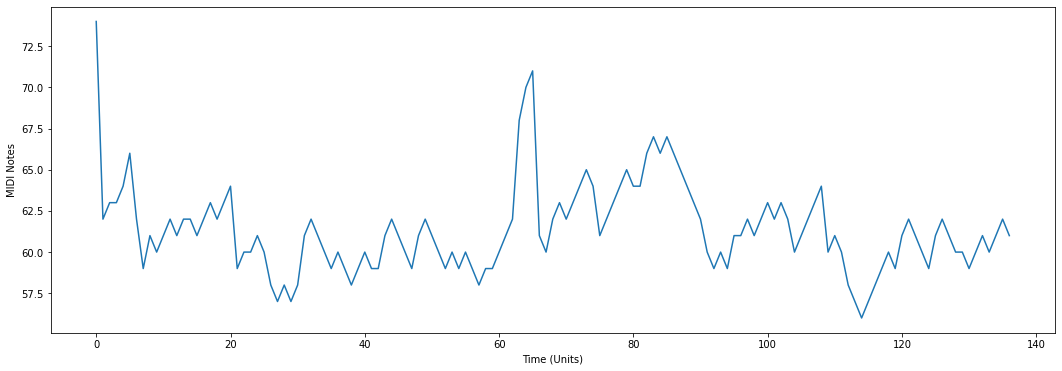

In [27]:
plt.figure(figsize=(18,6))
plt.plot(final_notes)
plt.xlabel('Time (Units)')
plt.ylabel('MIDI Notes')
plt.show()

In [ ]:
##now take the difference between each note
note_diff = np.ediff1d(final_notes)
note_diff = note_diff + abs(min(note_diff)) ## and make everything positive
note_diff = note_diff.astype(int)

In [ ]:
##fuzzy compare each base sections to each subsequent section
numnotes = len(note_diff)
breaks = np.arange(0,numnotes,5)
res = np.zeros(0)
for i in range(0,len(breaks)-1):
    base_pattern = note_diff[breaks[i]:breaks[i+1]]
    bpstr = ''.join(map(str, base_pattern))
    for j in range(i+1, len(breaks)-1):
        p2str = ''.join(map(str, note_diff[breaks[j]:breaks[j+1]]))
        res = np.append(res,fuzz.ratio(bpstr,p2str))

### End of Redundancy 

The following is how to record the computer sound into python for processing the spotify songs

In [ ]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 512
RECORD_SECONDS = 15

In [ ]:
audio = pyaudio.PyAudio()
stream = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,input_device_index = 10,
                frames_per_buffer=CHUNK)
print ("recording started")
Recordframes = []
 
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    Recordframes.append(data)
print ("recording stopped")
 
stream.stop_stream()
stream.close()
audio.terminate()

In [ ]:
Recordframes